# Topic Modelling

In [ ]:
!pip install gensim
!pip install pyldavis

In [ ]:
import pandas as pd
import numpy as np
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models as pgm
import spacy
from spacy.language import Language
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_lg
from tqdm import tqdm
from pprint import pprint
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# load data
ted = pd.read_csv('../data/processed/ted_measures.csv')
corp = ted['transcript']
t_corp = ted['title']

In [ ]:
# extend stop word list
stop_list = ["thank", "'s", "hello", "hi", "you", "greetings", "welcome", "said", "think", "laughter", "audience", "applause"]
ted_stoplist = ['got', 'like', 'million', 'thousand', 'thousands', 'country', 'time', 'actually', 'number', 'percent'] + stop_list
nlp. Defaults.stop_words.update(ted_stoplist)
for word in STOP_WORDS:
    lexeme = nlp.vocab[word]
    lexeme.is_stop = True

In [ ]:
# trained pipeline
nlp = spacy.load("en_core_web_lg")

@Language.component('noun_extraction')
def noun_phrase(doc):
    """Extract nouns"""

    doc = [token.text.lower() for token in doc if (token.tag_ == 'NN') and (token.is_stop != True and token.is_punct != True)]

    return doc

# add noun extraction pipeline in the spacy pipeline
nlp.add_pipe("noun_extraction", last=True) 

In [ ]:
# create a list of pipeline processed documents
doc_list = []
for doc in tqdm(corp):
    # Passes that article through the pipeline and adds to a new list.
    pr = nlp(doc)
    doc_list.append(pr)

# creates processed corpus
words = corpora.Dictionary(doc_list)
words.filter_extremes(no_below=5, no_above=0.5)

# turns each document into a bag of words.
corpus = [words.doc2bow(doc) for doc in doc_list]

In [ ]:
# train LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=words,
                                           chunksize=1000,
                                           num_topics=15, 
                                           random_state=2,
                                           update_every=1,
                                           passes=10,
                                           alpha='auto',
                                           eval_every=1,
                                           per_word_topics=True)


In [ ]:
# visualize results with pyLDAvis
pyLDAvis.enable_notebook()
pgm.prepare(lda_model, corpus, words)

In [ ]:
# label each topic based on inspecting output of above cell
topic_dict = {
    14: 'politics', 13: 'entertainment',  9: 'education', 3: 'environment', 4: 'design', 7: 'human feelings',
    12: 'astronomy', 6: 'technology', 2: 'economy', 1: 'gender equity', 11: 'posessions',
    15: 'evolutionary biology', 10: 'health', 5: 'brain', 8: 'community'
}

def get_topic(doc_topics, topic_dict):
    """
    Get topics for a document
    """

    topic_list = []

    for pr in lda_model[doc_topics]:
        if pr[0] in topic_dict:
            topic_list.append((topic_dict[pr[0]], pr[1]))
        else:
            topic_list.append(('unassigned_topic', pr[1]))

    return topic_list

def most_freq_topic(topics, topics_dict):
    """
    Get most common topic for a document
    """

    freq_topic = {}

    for doc in range(len(topics)):
        maxp = topics[doc][0][1]
        for t in range(15):
            p = topics[doc][t][1]
            if p > maxp:
                maxp = p
                best_t = t

        freq_topic[doc] = topics_dict[best_t]

    return freq_topic

In [ ]:
# get topics for documents
doc_topics = lda_model.get_document_topics(corpus, minimum_probability=None)
topics = get_topic(doc_topics, topic_dict)

# get most frequent topics
tops = [topic for topic in lda_model[doc_topics]]
ft = most_freq_topic(tops, topic_dict)

# update dataframe with most frequent topics
talk_topics = list(ft.values())
ted['most_frequent_topic'] = talk_topics

In [ ]:
# save file
ted[['talk_name', 'event_cat', 'views_x', 'p_year', 'mws', 'fkl', 'mtld', 'cnt_i', 'cnt_we', 'cnt_you', 'nip_comps_cnt', 'nip', 'nvr', 'time_period', 'most_frequent_topic']].to_csv('../data/processed/ted_topic_modelled.csv', index=False)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic

sns.set(style='white', rc={"grid.linewidth": 0.1})
sns.set_context("paper", font_scale=0.9)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [ ]:
# load data
ted = pd.read_csv('../data/processed/ted_topic_modelled.csv')

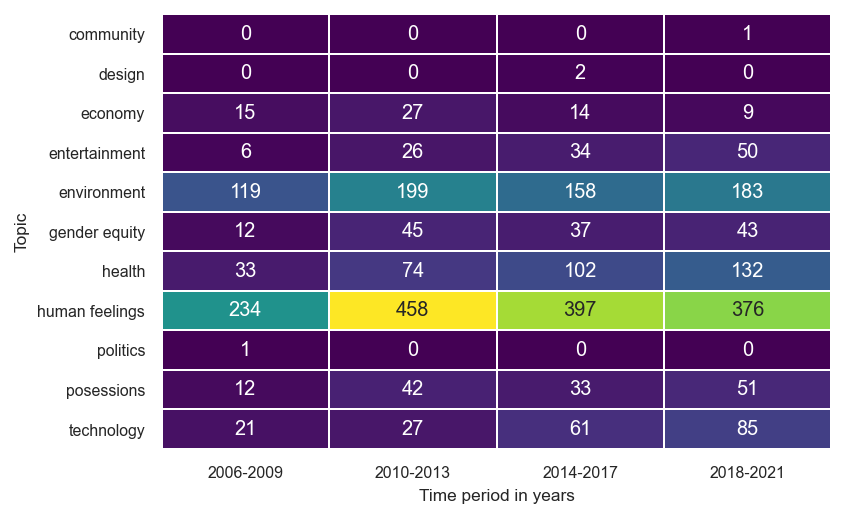

In [35]:
plt.figure(figsize=(6,4))
crosstable=pd.crosstab(ted['most_frequent_topic'], ted['time_period'])
ax = sns.heatmap(crosstable, annot=True, fmt='d', linewidths=1, cmap='viridis', cbar=False)
ax.set(xticklabels=['2006-2009', '2010-2013', '2014-2017', '2018-2021'])
plt.xlabel('Time period in years')
plt.ylabel('Topic')
plt.savefig('../reports/figures/topics.png', bbox_inches='tight')